In [126]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
!pip install torch_geometric
!pip install pyvista

Looking in links: https://data.pyg.org/whl/torch-2.4.0+cpu.html


In [127]:
import torch
import matplotlib.pyplot as plt
from utils import  DelaunayTransform
from torch_geometric.data import Data
import torch_geometric
import networkx as nx
import pyvista as pv
import numpy as np

In [128]:
pos = torch.rand((100, 3))
pos[:, 2] = 0
data = Data(pos=pos[:, :2], surf=torch.full((100, 1), False))
transform = DelaunayTransform()
data = transform(data)
data.pos = pos

mesh = pv.PolyData()
mesh.points = data.pos.numpy()
edges = data.edge_index.t().numpy()
lines = np.hstack([np.full((edges.shape[0], 1), 2), edges]).ravel()
mesh.lines = lines


/opt/homebrew/anaconda3/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


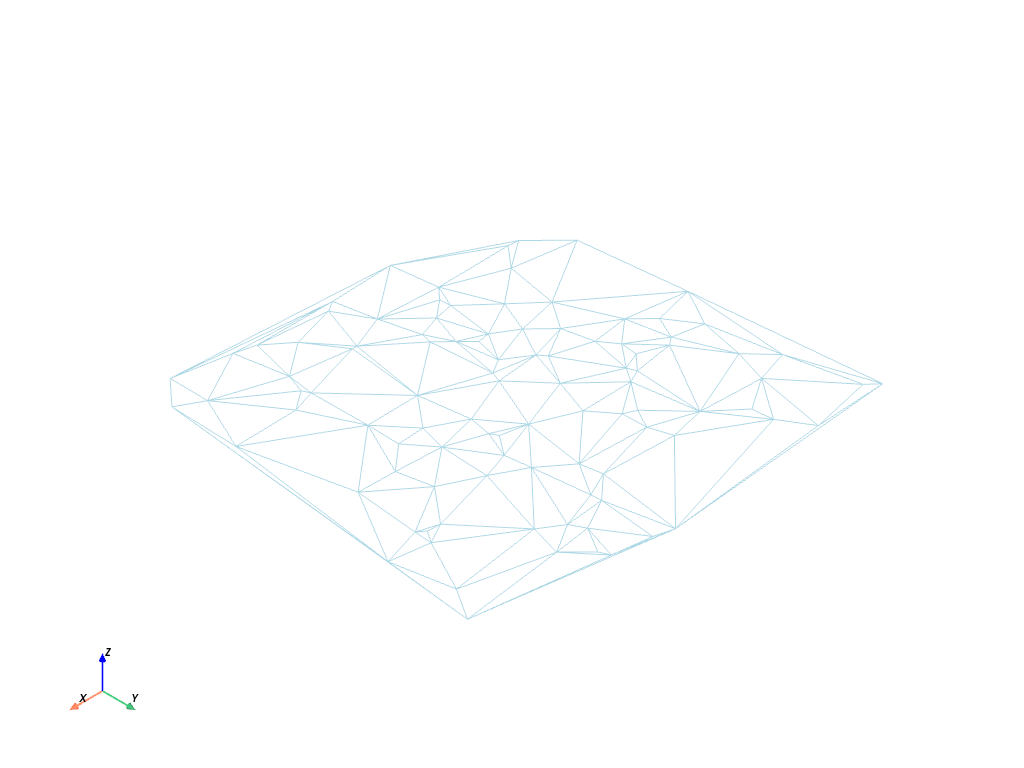

In [129]:
mesh.plot(show_edges=True, line_width=1)


In [150]:
def divide_mesh(v, e, k):
    clusters = [Data(edge_index=torch.Tensor([])) for i in range(k)]
    
    centroids = torch.rand((k, 2))
    
    for _ in range(1):
        edges_distanes = v[e[:, 1]] - v[e[:, 0]]
        for i, e_ij in enumerate(edges_distanes):
            edge = e[i]
            angles = torch.acos(torch.matmul(e_ij, centroids.T)/(torch.norm(e_ij)*torch.norm(centroids, dim=1)))
            min_edge_idx = torch.argmin(angles)
            clusters[min_edge_idx].edge_index = torch.cat([clusters[min_edge_idx].edge_index, edge.view(1, -1)])

    return clusters
data.pos = data.pos[:, :2]
divide_mesh(data.pos, data.edge_index.T, 3)

[Data(edge_index=[125, 2]),
 Data(edge_index=[26, 2]),
 Data(edge_index=[137, 2])]